In [1]:
# ===========================================================
# 0. IMPORTAÇÕES
# ===========================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.utils import resample
import joblib
import time

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100



In [11]:
# ===========================================================
# 1. CARREGAR DATASET COM CLUSTER_ID E AJUSTAR DATAS
# ===========================================================
# =========================================================
#  IMPORTS E CONFIGURAÇÃO DE CAMINHOS
# =========================================================

import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display

# ---------------------------------------------------------
# Caminho base do projeto (raiz do repositório)
# ---------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent

# ---------------------------------------------------------
# Caminhos dos dados
# ---------------------------------------------------------
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" / "df_com_cluster_id.parquet"

# =========================================================
# Carregar dataset
# =========================================================
df = pd.read_parquet(DATA_PROCESSED_PATH)

print("Dimensão do df:", df.shape)
display(df.head())


# Garantir year_month_dt
if "year_month_dt" not in df.columns:
    df["year_month"] = df["year_month"].astype(str)
    df["year_month_dt"] = pd.to_datetime(df["year_month"], format="%Y-%m")

# Conferência rápida de colunas relevantes
cols_relevantes = [
    "year_month", "year_month_dt",
    "item", "store_code", "mean_price", "sales",
    "time_index", "month_sin", "month_cos", "cluster_id"
]
print("\nColunas relevantes encontradas no df:")
print([c for c in cols_relevantes if c in df.columns])



Dimensão do df: (1219600, 15)


,year_month,item,category,department,store_code,region,sales,mean_price,year,year_month_dt,month,time_index,month_sin,month_cos,cluster_id
0,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,Boston,0.0,10.9858,2013,2013-01-01,1,0,0.5,0.866025,3
1,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Boston,0.0,10.9858,2013,2013-01-01,1,0,0.5,0.866025,3
2,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Boston,0.0,10.9858,2013,2013-01-01,1,0,0.5,0.866025,3
3,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,0.0,10.9858,2013,2013-01-01,1,0,0.5,0.866025,3
4,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,New York,0.0,10.9858,2013,2013-01-01,1,0,0.5,0.866025,3



Colunas relevantes encontradas no df:
['year_month', 'year_month_dt', 'item', 'store_code', 'mean_price', 'sales', 'time_index', 'month_sin', 'month_cos', 'cluster_id']


In [3]:
# ===========================================================
# 2. GARANTIR FEATURES TEMPORAIS (time_index, month_sin, month_cos)
# ===========================================================

# month
if "month" not in df.columns:
    df["month"] = df["year_month_dt"].dt.month

# time_index
if "time_index" not in df.columns:
    data_min = df["year_month_dt"].min()
    df["time_index"] = (df["year_month_dt"].dt.year - data_min.year) * 12 + \
                       (df["year_month_dt"].dt.month - data_min.month)

# month_sin e month_cos
if "month_sin" not in df.columns:
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
if "month_cos" not in df.columns:
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df[["year_month", "time_index", "month", "month_sin", "month_cos", "cluster_id"]].head()



,year_month,time_index,month,month_sin,month_cos,cluster_id
0,2013-01,0,1,0.5,0.866025,3
1,2013-01,0,1,0.5,0.866025,3
2,2013-01,0,1,0.5,0.866025,3
3,2013-01,0,1,0.5,0.866025,3
4,2013-01,0,1,0.5,0.866025,3


In [4]:

# ===========================================================
# 3. CRIAÇÃO DE FEATURES NUMÉRICAS PARA LOJA E ITEM
# ===========================================================

# Média histórica de vendas por item
df["item_mean_sales"] = df.groupby("item")["sales"].transform("mean")

# Média histórica de vendas por loja
df["store_mean_sales"] = df.groupby("store_code")["sales"].transform("mean")

# (Opcional) média histórica por combinação loja+item
df["store_item_mean_sales"] = df.groupby(["store_code", "item"])["sales"].transform("mean")

df[["item", "store_code", "sales",
    "item_mean_sales", "store_mean_sales", "store_item_mean_sales"]].head()



,item,store_code,sales,item_mean_sales,store_mean_sales,store_item_mean_sales
0,ACCESORIES_1_001,BOS_1,0.0,10.2325,30.597122,6.500
1,ACCESORIES_1_001,BOS_2,0.0,10.2325,38.484249,10.050
2,ACCESORIES_1_001,BOS_3,0.0,10.2325,34.036996,9.625
3,ACCESORIES_1_001,NYC_1,0.0,10.2325,42.891038,15.000
4,ACCESORIES_1_001,NYC_2,0.0,10.2325,31.378386,13.550


In [5]:
# ===========================================================
# 4. DEFINIÇÃO DO TARGET E DAS FEATURES
# ===========================================================

target_col = "sales"
assert target_col in df.columns, "A coluna 'sales' não foi encontrada no df."

numeric_features = [
    "mean_price",
    "time_index",
    "month_sin",
    "month_cos",
    "cluster_id",
    "item_mean_sales",
    "store_mean_sales",
    "store_item_mean_sales",
]

# Só usamos features numéricas (sem One-Hot para item/store_code)
X = df[numeric_features].copy()
y = df[target_col].copy()

print("Features numéricas usadas:", numeric_features)
print("Shape de X:", X.shape, "| Shape de y:", y.shape)



Features numéricas usadas: ['mean_price', 'time_index', 'month_sin', 'month_cos', 'cluster_id', 'item_mean_sales', 'store_mean_sales', 'store_item_mean_sales']
Shape de X: (1219600, 8) | Shape de y: (1219600,)


In [6]:
# ===========================================================
# 5. SEPARAÇÃO TREINO/TESTE BASEADA EM TEMPO_INDEX
# ===========================================================

if "time_index" in df.columns:
    limite_tempo_treino = df["time_index"].max() - 6  # últimos 6 meses para teste
    print("Limite de time_index para treino:", limite_tempo_treino)

    mask_treino = df["time_index"] <= limite_tempo_treino
    mask_teste  = df["time_index"] >  limite_tempo_treino

    X_train, X_test = X[mask_treino], X[mask_teste]
    y_train, y_test = y[mask_treino], y[mask_teste]
else:
    print("Atenção: 'time_index' não encontrado, usando split aleatório 80/20.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print("Tamanho treino:", X_train.shape[0])
print("Tamanho teste :", X_test.shape[0])


Limite de time_index para treino: 33
Tamanho treino: 1036660
Tamanho teste : 182940


In [7]:
# ===========================================================
# 6. PRÉ-PROCESSAMENTO NUMÉRICO (STANDARD SCALER)
# ===========================================================

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
    ]
)

# Ajustar o scaler com dados de treino e transformar treino/teste
preprocess.fit(X_train)

X_train_proc = preprocess.transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Shapes após pré-processamento:")
print("X_train_proc:", X_train_proc.shape)
print("X_test_proc :", X_test_proc.shape)


Shapes após pré-processamento:
X_train_proc: (1036660, 8)
X_test_proc : (182940, 8)


In [8]:
# ===========================================================
# 7. COMPARAÇÃO DOS MODELOS NA AMOSTRA DO TREINO
#    (Ridge, RandomForest, LightGBM, XGBoost)
# ===========================================================

# 7.1 Amostra do treino para comparação
n_amostra = 10000  # ajuste para 5000 se ainda ficar pesado

n_treino = X_train_proc.shape[0]
if n_treino > n_amostra:
    np.random.seed(42)
    idx_amostra = np.random.choice(n_treino, size=n_amostra, replace=False)
    X_train_small = X_train_proc[idx_amostra]
    y_train_small = y_train.iloc[idx_amostra]
    print(f"Usando amostra de {n_amostra} linhas (de {n_treino}) para comparar modelos.")
else:
    X_train_small = X_train_proc
    y_train_small = y_train
    print(f"Tamanho do treino ({n_treino}) menor que a amostra; usando tudo.")

# 7.2 Definição dos modelos com configurações leves
modelos = {
    "Ridge (baseline)": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=80,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ),
}

resultados_lista = []

for nome, modelo in modelos.items():
    print(f"\nTreinando modelo (amostra): {nome}")
    inicio = time.time()
    modelo.fit(X_train_small, y_train_small)
    fim = time.time()

    y_pred = modelo.predict(X_test_proc)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"Tempo de treino: {fim - inicio:.2f} s")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    resultados_lista.append({
        "modelo": nome,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "tempo_treino_seg": fim - inicio,
    })

resultados_df = pd.DataFrame(resultados_lista).sort_values("RMSE")
print("\nRESULTADOS (ordenado por RMSE):")
display(resultados_df)


Usando amostra de 10000 linhas (de 1036660) para comparar modelos.

Treinando modelo (amostra): Ridge (baseline)
Tempo de treino: 0.01 s
RMSE: 43.5649 | MAE: 16.8072 | R²: 0.7362

Treinando modelo (amostra): RandomForest
Tempo de treino: 0.25 s
RMSE: 44.8150 | MAE: 17.3772 | R²: 0.7208

Treinando modelo (amostra): LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 8
[LightGBM] [Info] Start training from score 36.305100


c:\app\MarketingAI\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\app\MarketingAI\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Tempo de treino: 0.20 s
RMSE: 49.6931 | MAE: 18.2432 | R²: 0.6567

Treinando modelo (amostra): XGBoost
Tempo de treino: 0.35 s
RMSE: 50.0534 | MAE: 18.4151 | R²: 0.6517

RESULTADOS (ordenado por RMSE):


,modelo,RMSE,MAE,R2,tempo_treino_seg
0,Ridge (baseline),43.564931,16.807248,0.736185,0.007004
1,RandomForest,44.815002,17.377225,0.720828,0.252388
2,LightGBM,49.693094,18.243172,0.656745,0.202098
3,XGBoost,50.053427,18.415063,0.651749,0.354215


In [9]:
# ===========================================================
# 8. TREINO FINAL DO MELHOR MODELO E SALVAMENTO
# ===========================================================

# Melhor modelo pela amostra (menor RMSE)
nome_melhor = resultados_df.iloc[0]["modelo"]
print("Melhor modelo pela amostra:", nome_melhor)

# Recupera o modelo base e clona os hiperparâmetros
modelo_base = modelos[nome_melhor]
melhor_modelo_final = modelo_base.__class__(**modelo_base.get_params())

print("\nTreinando o melhor modelo no treino COMPLETO...")
inicio = time.time()
melhor_modelo_final.fit(X_train_proc, y_train)
fim = time.time()
print(f"Tempo de treino final (completo): {fim - inicio:.2f} s")

# Avaliação final no teste
y_pred_best = melhor_modelo_final.predict(X_test_proc)

mse_best  = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best  = mean_absolute_error(y_test, y_pred_best)
r2_best   = r2_score(y_test, y_pred_best)

print("\nDESEMPENHO FINAL DO MELHOR MODELO (treino completo):")
print(f"Modelo: {nome_melhor}")
print(f"RMSE: {rmse_best:.4f} | MAE: {mae_best:.4f} | R²: {r2_best:.4f}")

# Salvar preprocessador e modelo separadamente para o app
joblib.dump(preprocess, "preprocess_predicao.pkl")
joblib.dump(melhor_modelo_final, "best_model.pkl")

print("\nArtefatos salvos: preprocess_predicao.pkl e best_model.pkl")


Melhor modelo pela amostra: Ridge (baseline)

Treinando o melhor modelo no treino COMPLETO...
Tempo de treino final (completo): 0.08 s

DESEMPENHO FINAL DO MELHOR MODELO (treino completo):
Modelo: Ridge (baseline)
RMSE: 44.2609 | MAE: 16.9025 | R²: 0.7277

Artefatos salvos: preprocess_predicao.pkl e best_model.pkl


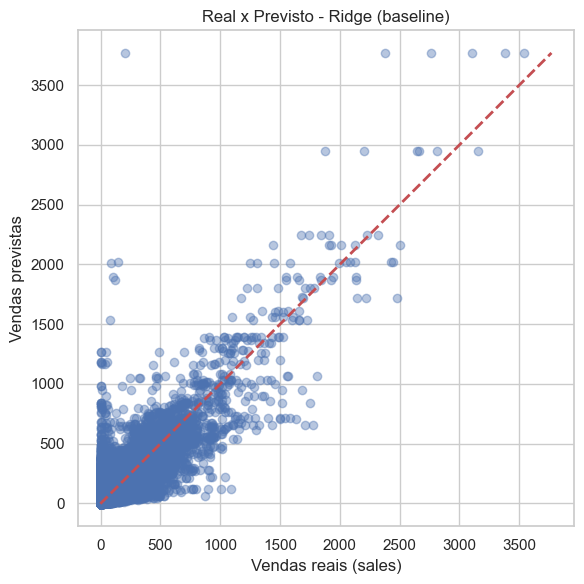

In [10]:
# ===========================================================
# 9. GRÁFICO REAL x PREVISTO DO MELHOR MODELO
# ===========================================================

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.4)
lim_min = min(y_test.min(), y_pred_best.min())
lim_max = max(y_test.max(), y_pred_best.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], "r--", linewidth=2)

plt.xlabel("Vendas reais (sales)")
plt.ylabel("Vendas previstas")
plt.title(f"Real x Previsto - {nome_melhor}")
plt.tight_layout()
plt.show()


 - Comparação dos modelos de predição

  Foram avaliados quatro modelos de regressão – **Ridge (baseline)**, **Random Forest**, **LightGBM** e **XGBoost** – utilizando as mesmas variáveis explicativas (`mean_price`, `time_index`, `month_sin`, `month_cos`, `cluster_id`, `item_mean_sales`, `store_mean_sales`, `store_item_mean_sales`) e o mesmo conjunto de treino e teste. A Tabela de resultados mostra que o **Ridge** apresentou o **menor RMSE (43,56)**, o **menor MAE (16,81)** e o **maior R² (0,736)**, além de tempo de treino praticamente instantâneo. Em seguida aparecem Random Forest e, por último, LightGBM e XGBoost, com RMSE e R² inferiores.

Apesar da expectativa teórica de que modelos baseados em árvores de decisão em conjunto (como LightGBM e XGBoost) tendam a apresentar desempenho superior em problemas de predição, neste caso específico o **modelo linear regularizado (Ridge)** se mostrou mais adequado. Isso se explica, principalmente, por três fatores: (i) as features utilizadas são essencialmente numéricas e já bastante informativas (incluindo médias históricas por loja e item e o `cluster_id`), o que favorece um relacionamento aproximadamente linear com as vendas; (ii) a regularização do Ridge ajuda a estabilizar o ajuste em um espaço de atributos relativamente denso, reduzindo overfitting; e (iii) os hiperparâmetros dos modelos baseados em árvores foram mantidos em configurações mais conservadoras para reduzir o custo computacional, o que limita sua capacidade de capturar padrões mais complexos. Em resumo, os resultados empíricos indicam que, para este conjunto de dados e configuração adotada, o **Ridge** é o modelo que oferece o melhor compromisso entre desempenho preditivo e simplicidade.
